# Trading Strategy Backtest for BTC/USDT

**Overview:**

This notebook implements a trading strategy for BTC/USDT using technical indicators and backtesting. The strategy generates buy and sell signals based on a composite indicator, employing a trailing stop-loss for risk management.

**Key Steps:**

1. **Data Loading and Preprocessing**
2. **Technical Indicator Calculation**
3. **Missing Value Handling**
4. **Composite Indicator and Signal Generation**
5. **Trading Strategy Definition**
6. **Backtesting**
7. **Results Analysis**

**Code:**

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore') #Suppress warnings for cleaner output

import time 
import ta # Technical analysis library
import pandas_ta as p_ta # Additional technical analysis functions

In [2]:
# Load the BTC/USDT price data from the CSV file
data = pd.read_csv("btc_1h.csv")

In [3]:
# Set the datetime column as the index and rename columns for clarity
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime',inplace=True)
data.rename(columns = {'open':'Open' , 'close':'Close' ,'high' : 'High','low': 'Low'},inplace = True)

In [4]:
# data preview
data

Open      High       Low     Close       volume
datetime                                                                
2018-01-01 05:30:00  13715.65  13715.65  13400.01  13529.01   443.356199
2018-01-01 06:30:00  13528.99  13595.89  13155.38  13203.06   383.697006
2018-01-01 07:30:00  13203.00  13418.43  13200.00  13330.18   429.064572
2018-01-01 08:30:00  13330.26  13611.27  13290.00  13410.03   420.087030
2018-01-01 09:30:00  13434.98  13623.29  13322.15  13601.01   340.807329
...                       ...       ...       ...       ...          ...
2022-01-31 01:30:00  37512.37  37740.00  37351.63  37684.45  1037.922560
2022-01-31 02:30:00  37684.45  37762.60  37492.25  37729.00   874.060520
2022-01-31 03:30:00  37729.00  37855.54  37625.41  37785.78   734.658550
2022-01-31 04:30:00  37785.78  38230.00  37778.46  37881.76  1728.811800
2022-01-31 05:30:00  37881.75  37951.07  36828.32  36829.30  2907.710960

[35664 rows x 5 columns]

In [5]:
# Function to calculate technical indicators
def create_features(data):
    
    
    # Calculate RSI :
    closing_prices=np.array(data["Close"])
    period = 14
    # Calculate price differences
    deltas = np.diff(closing_prices)
    gains = np.clip(deltas, 0, None)
    losses = np.clip(deltas, None, 0)
    # Create empty lists to store average gains and losses
    avg_gains = []
    avg_losses = []
    # Calculate average gains and losses for each period
    for i in range(len(closing_prices)):
        if i < period - 1:
            avg_gain = np.mean(gains[:i+1])
            avg_loss = -np.mean(losses[:i+1])
        else:
            avg_gain = np.mean(gains[i-period+1:i+1])
            avg_loss = -np.mean(losses[i-period+1:i+1])
        avg_gains.append(avg_gain)
        avg_losses.append(avg_loss)
    # Calculate the RS and RSI values for each period
    rs = [avg_gain / avg_loss for avg_gain, avg_loss in zip(avg_gains, avg_losses)]
    rsi = [100 - (100 / (1 + rsi_val)) for rsi_val in rs]
    data["RSI_14"]=rsi
    
    
    #Calculate Stochastic MACD :
    macd_short=12
    macd_long=26
    k_period=14
    data["MACD"] = data['Close'].ewm(span=macd_short).mean() - data['Close'].ewm(span=macd_long).mean()
    lowest_macd = data["MACD"].rolling(window=k_period).min()
    highest_macd = data["MACD"].rolling(window=k_period).max()
    data["Stoch_MACD"] = 100 * (data["MACD"] - lowest_macd) / (highest_macd - lowest_macd)
    data.drop('MACD',axis = 1,inplace=True)
    
    
    #Calculate Stochastic EMA :
    k_period = 14
    lowest_low = data["Low"].rolling(window=k_period).min()
    highest_high = data["High"].rolling(window=k_period).max()
    data["Stoch_EMA"] = 100 * (data["Close"] - lowest_low) / (highest_high - lowest_low)
    
    
    #Calculate Stochastic Oscillators :
    data.ta.stoch(high='High', low='Low', close='Close', k=14, append=True)
    data.drop('STOCHd_14_3_3',axis = 1,inplace=True)#Remove the %D values
    data["Stoch_OSC"] = data["STOCHk_14_3_3"]
    data.drop('STOCHk_14_3_3',axis = 1,inplace=True)
    
    #Calculate ADX :
    adx = ta.trend.ADXIndicator(high=data['High'], low=data['Low'], close=data['Close'], window=14)#Calculate ADX
    data['ADX_14'] = adx.adx()  # Add ADX values as a new column
     #Calculate ATR
    window = 14
    data['H-L'] = data['High'] - data['Low']  # High minus Low
    data['H-PC'] = abs(data['High'] - data['Close'].shift(1))  # Absolute value of High minus previous Close
    data['L-PC'] = abs(data['Low'] - data['Close'].shift(1))  # Absolute value of Low minus previous Close
    data['TR'] = data[['H-L', 'H-PC', 'L-PC']].max(axis=1)  # True Range
    data['ATR'] = data['TR'].rolling(window=window).mean()  # Calculate ATR using rolling mean
    return data

In [6]:
create_features(data)

Open      High       Low     Close       volume  \
datetime                                                                   
2018-01-01 05:30:00  13715.65  13715.65  13400.01  13529.01   443.356199   
2018-01-01 06:30:00  13528.99  13595.89  13155.38  13203.06   383.697006   
2018-01-01 07:30:00  13203.00  13418.43  13200.00  13330.18   429.064572   
2018-01-01 08:30:00  13330.26  13611.27  13290.00  13410.03   420.087030   
2018-01-01 09:30:00  13434.98  13623.29  13322.15  13601.01   340.807329   
...                       ...       ...       ...       ...          ...   
2022-01-31 01:30:00  37512.37  37740.00  37351.63  37684.45  1037.922560   
2022-01-31 02:30:00  37684.45  37762.60  37492.25  37729.00   874.060520   
2022-01-31 03:30:00  37729.00  37855.54  37625.41  37785.78   734.658550   
2022-01-31 04:30:00  37785.78  38230.00  37778.46  37881.76  1728.811800   
2022-01-31 05:30:00  37881.75  37951.07  36828.32  36829.30  2907.710960   

                        RSI_14  Stoch_MACD  Stoch_EMA  Stoch_OSC     ADX_14  \
datetime                                                                      
2018-01-01 05:30:00   0.000000         NaN        NaN        NaN   0.000000   
2018-01-01 06:30:00  28.057475         NaN        NaN        NaN   0.000000   
2018-01-01 07:30:00  38.836974         NaN        NaN        NaN   0.000000   
2018-01-01 08:30:00  54.973063         NaN        NaN        NaN   0.000000   
2018-01-01 09:30:00  51.957123         NaN        NaN        NaN   0.000000   
...                        ...         ...        ...        ...        ...   
2022-01-31 01:30:00  38.211991    0.000000  33.029981  19.158480  15.629585   
2022-01-31 02:30:00  44.645517    0.000000  37.451247  26.033540  16.031472   
2022-01-31 03:30:00  49.805624    0.000000  47.839693  39.440307  15.870665   
2022-01-31 04:30:00  25.293105    4.632551  58.415885  47.902275  15.468008   
2022-01-31 05:30:00  26.001379    0.000000   0.068492  35.441357  16.512183   

                         H-L    H-PC     L-PC       TR         ATR  
datetime                                                            
2018-01-01 05:30:00   315.64     NaN      NaN   315.64         NaN  
2018-01-01 06:30:00   440.51   66.88   373.63   440.51         NaN  
2018-01-01 07:30:00   218.43  215.37     3.06   218.43         NaN  
2018-01-01 08:30:00   321.27  281.09    40.18   321.27         NaN  
2018-01-01 09:30:00   301.14  213.26    87.88   301.14         NaN  
...                      ...     ...      ...      ...         ...  
2022-01-31 01:30:00   388.37  227.63   160.74   388.37  289.494286  
2022-01-31 02:30:00   270.35   78.15   192.20   270.35  295.127143  
2022-01-31 03:30:00   230.13  126.54   103.59   230.13  283.485714  
2022-01-31 04:30:00   451.54  444.22     7.32   451.54  295.849286  
2022-01-31 05:30:00  1122.75   69.31  1053.44  1122.75  350.317857  

[35664 rows x 15 columns]

In [7]:
data

Open      High       Low     Close       volume  \
datetime                                                                   
2018-01-01 05:30:00  13715.65  13715.65  13400.01  13529.01   443.356199   
2018-01-01 06:30:00  13528.99  13595.89  13155.38  13203.06   383.697006   
2018-01-01 07:30:00  13203.00  13418.43  13200.00  13330.18   429.064572   
2018-01-01 08:30:00  13330.26  13611.27  13290.00  13410.03   420.087030   
2018-01-01 09:30:00  13434.98  13623.29  13322.15  13601.01   340.807329   
...                       ...       ...       ...       ...          ...   
2022-01-31 01:30:00  37512.37  37740.00  37351.63  37684.45  1037.922560   
2022-01-31 02:30:00  37684.45  37762.60  37492.25  37729.00   874.060520   
2022-01-31 03:30:00  37729.00  37855.54  37625.41  37785.78   734.658550   
2022-01-31 04:30:00  37785.78  38230.00  37778.46  37881.76  1728.811800   
2022-01-31 05:30:00  37881.75  37951.07  36828.32  36829.30  2907.710960   

                        RSI_14  Stoch_MACD  Stoch_EMA  Stoch_OSC     ADX_14  \
datetime                                                                      
2018-01-01 05:30:00   0.000000         NaN        NaN        NaN   0.000000   
2018-01-01 06:30:00  28.057475         NaN        NaN        NaN   0.000000   
2018-01-01 07:30:00  38.836974         NaN        NaN        NaN   0.000000   
2018-01-01 08:30:00  54.973063         NaN        NaN        NaN   0.000000   
2018-01-01 09:30:00  51.957123         NaN        NaN        NaN   0.000000   
...                        ...         ...        ...        ...        ...   
2022-01-31 01:30:00  38.211991    0.000000  33.029981  19.158480  15.629585   
2022-01-31 02:30:00  44.645517    0.000000  37.451247  26.033540  16.031472   
2022-01-31 03:30:00  49.805624    0.000000  47.839693  39.440307  15.870665   
2022-01-31 04:30:00  25.293105    4.632551  58.415885  47.902275  15.468008   
2022-01-31 05:30:00  26.001379    0.000000   0.068492  35.441357  16.512183   

                         H-L    H-PC     L-PC       TR         ATR  
datetime                                                            
2018-01-01 05:30:00   315.64     NaN      NaN   315.64         NaN  
2018-01-01 06:30:00   440.51   66.88   373.63   440.51         NaN  
2018-01-01 07:30:00   218.43  215.37     3.06   218.43         NaN  
2018-01-01 08:30:00   321.27  281.09    40.18   321.27         NaN  
2018-01-01 09:30:00   301.14  213.26    87.88   301.14         NaN  
...                      ...     ...      ...      ...         ...  
2022-01-31 01:30:00   388.37  227.63   160.74   388.37  289.494286  
2022-01-31 02:30:00   270.35   78.15   192.20   270.35  295.127143  
2022-01-31 03:30:00   230.13  126.54   103.59   230.13  283.485714  
2022-01-31 04:30:00   451.54  444.22     7.32   451.54  295.849286  
2022-01-31 05:30:00  1122.75   69.31  1053.44  1122.75  350.317857  

[35664 rows x 15 columns]

In [8]:
#Interpolate Missing Values using Linear Interpolation
data['ADX_14'].interpolate(method='linear',limit_direction='backward',inplace=True)
data['Stoch_MACD'].interpolate(method='linear',limit_direction='backward',inplace=True)
data['Stoch_EMA'].interpolate(method='linear',limit_direction='backward',inplace=True)
data['Stoch_OSC'].interpolate(method='linear',limit_direction='backward',inplace=True)
data['ATR'].interpolate(method='linear',limit_direction='backward',inplace=True)

In [9]:
#Calculate the Composite Indicator based on ADX and other indicators
data['composite'] = np.where(data['ADX_14']<=25,(0.3*(data['RSI_14']+data['Stoch_OSC']) + 0.2*(data['Stoch_EMA'] + data['Stoch_MACD'])),np.where(((data['ADX_14']<=50) & (data['ADX_14']>25)),(0.25*(data['RSI_14']+data['Stoch_OSC']) + 0.25*(data['Stoch_EMA'] + data['Stoch_MACD'])),np.where(((data['ADX_14']<=75) & (data['ADX_14']>50)),(0.225*(data['RSI_14']+data['Stoch_OSC']) + 0.275*(data['Stoch_EMA'] + data['Stoch_MACD'])),np.where(((data['ADX_14']<=100) & (data['ADX_14']>75)),(0.2*(data['RSI_14']+data['Stoch_OSC']) + 0.3*(data['Stoch_EMA'] + data['Stoch_MACD'])),0))))

# Plots of Technical Indicators vs Time

**RSI vs Time**
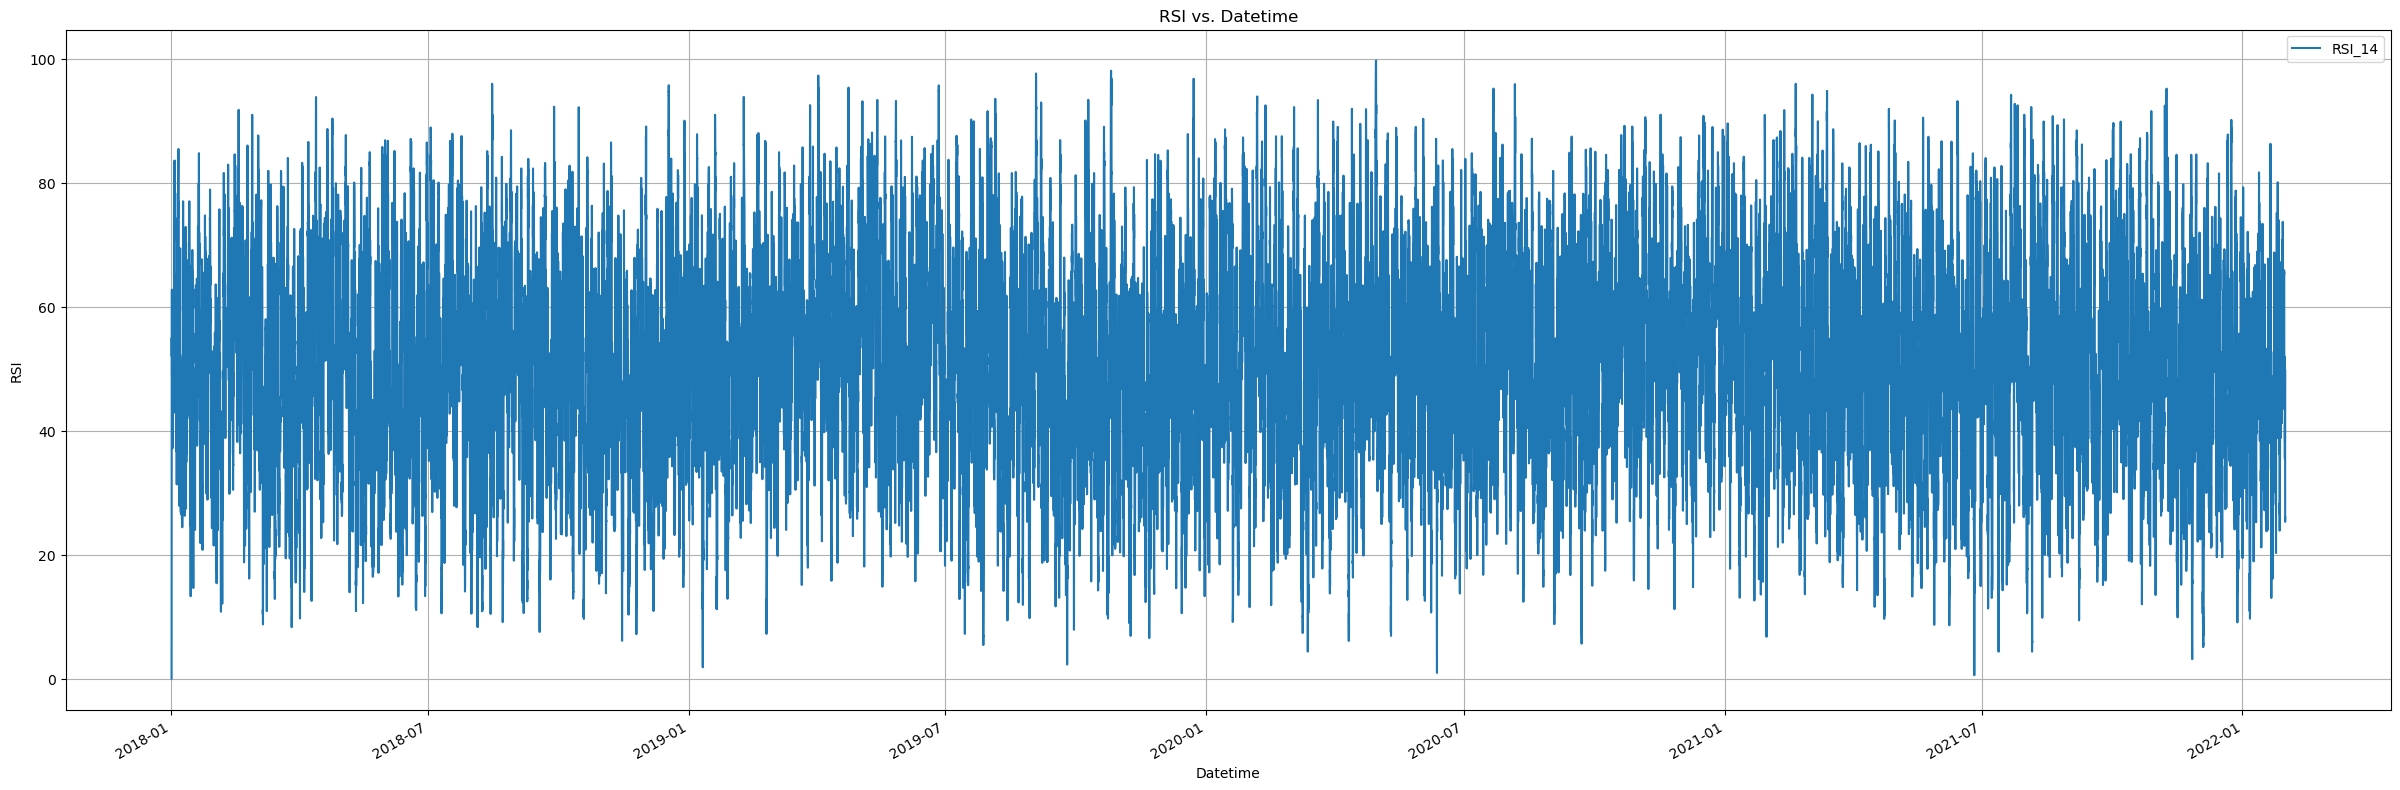


**Stoch_MACD vs Time**
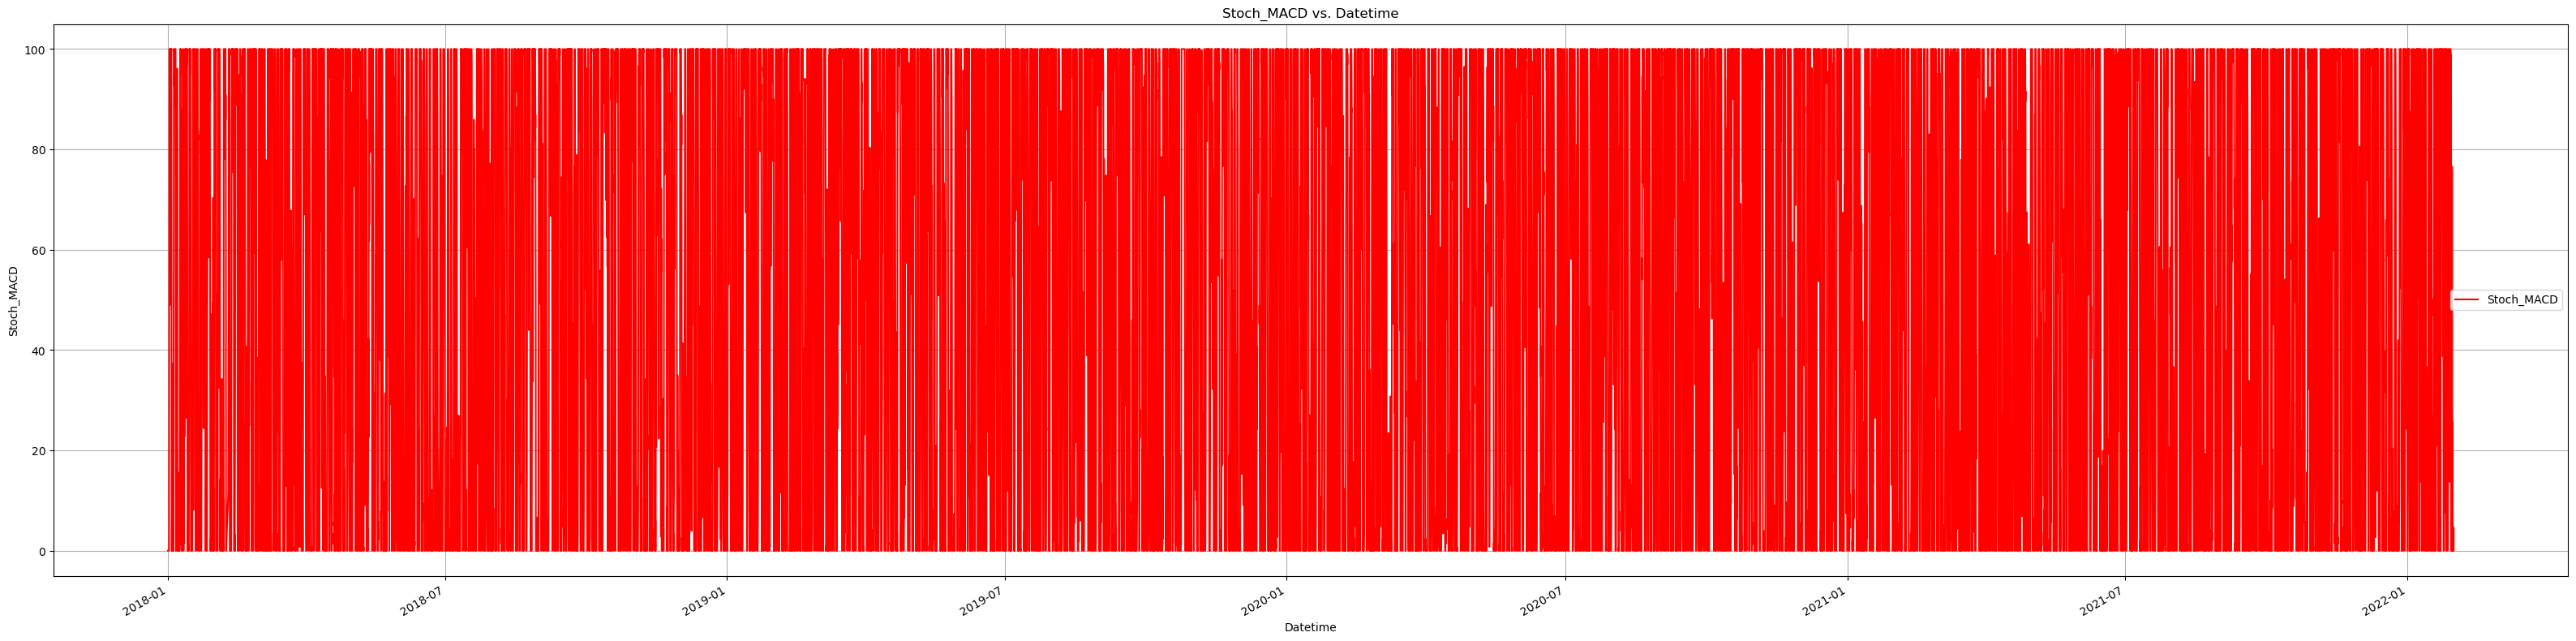

**Stoch_EMA vs Time**
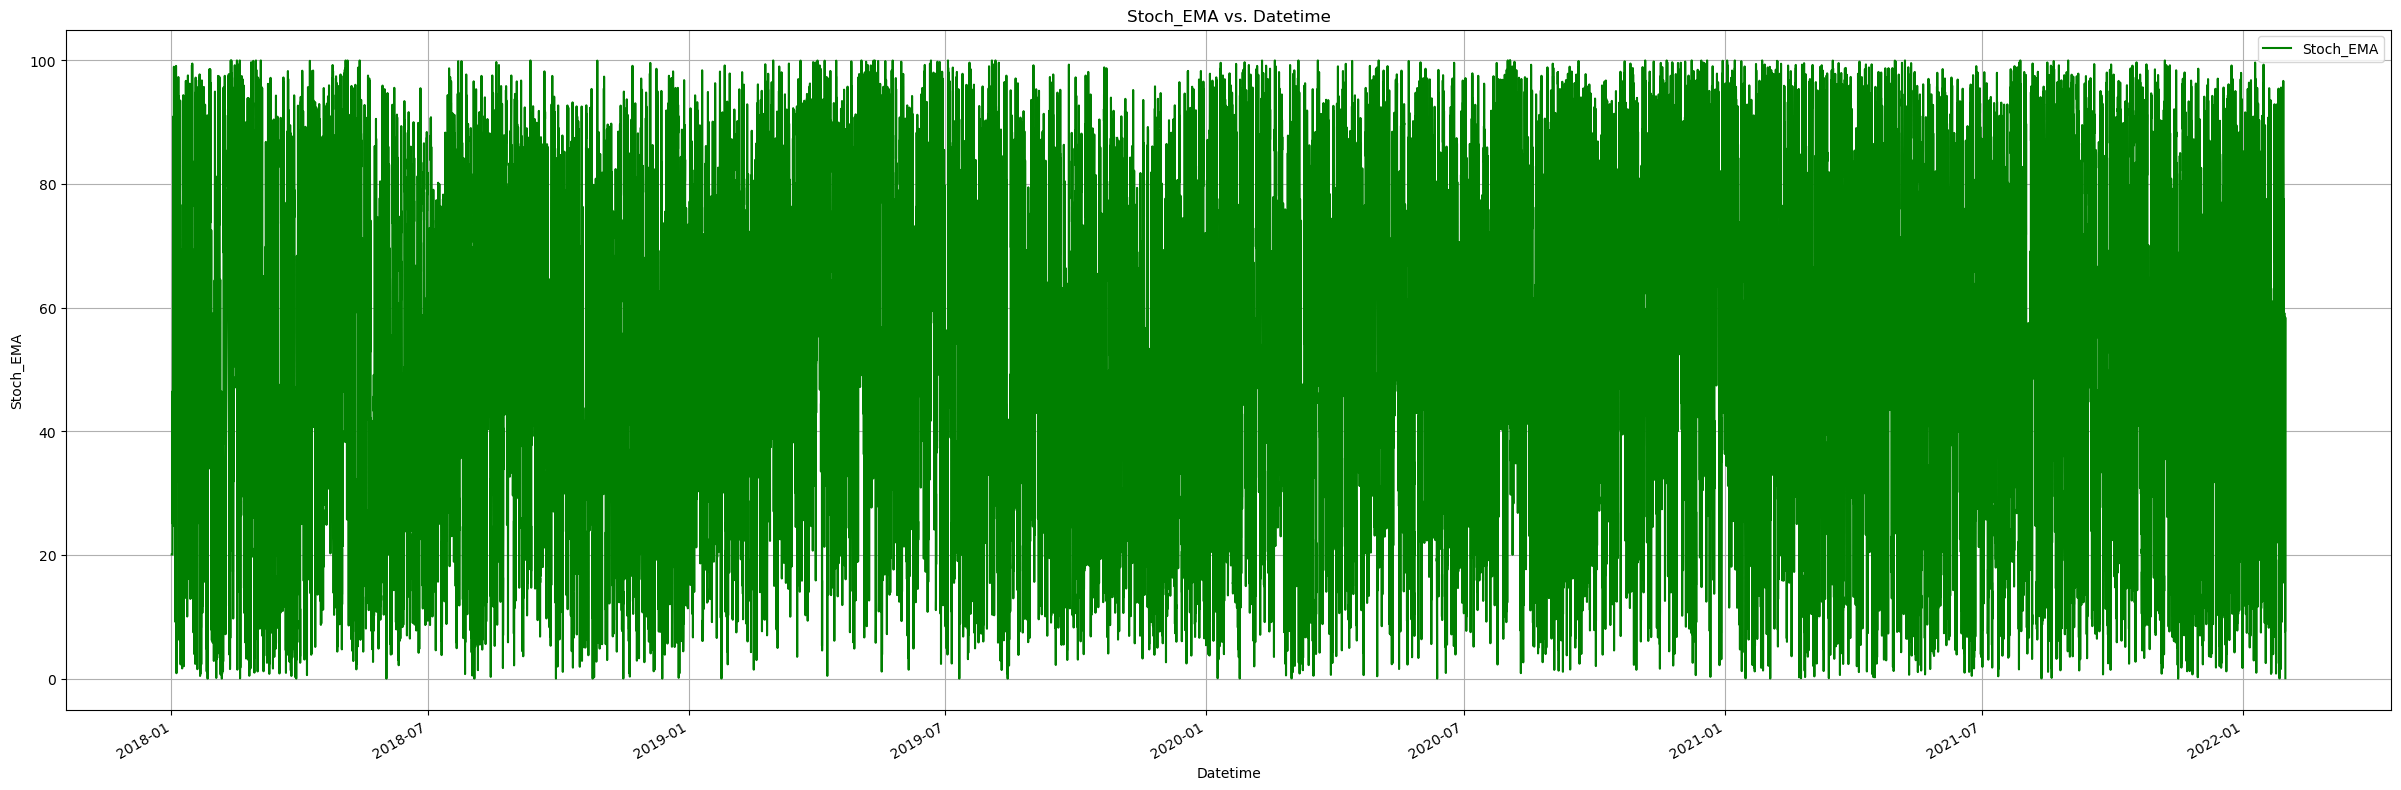

**Stoch_OSC vs Time**
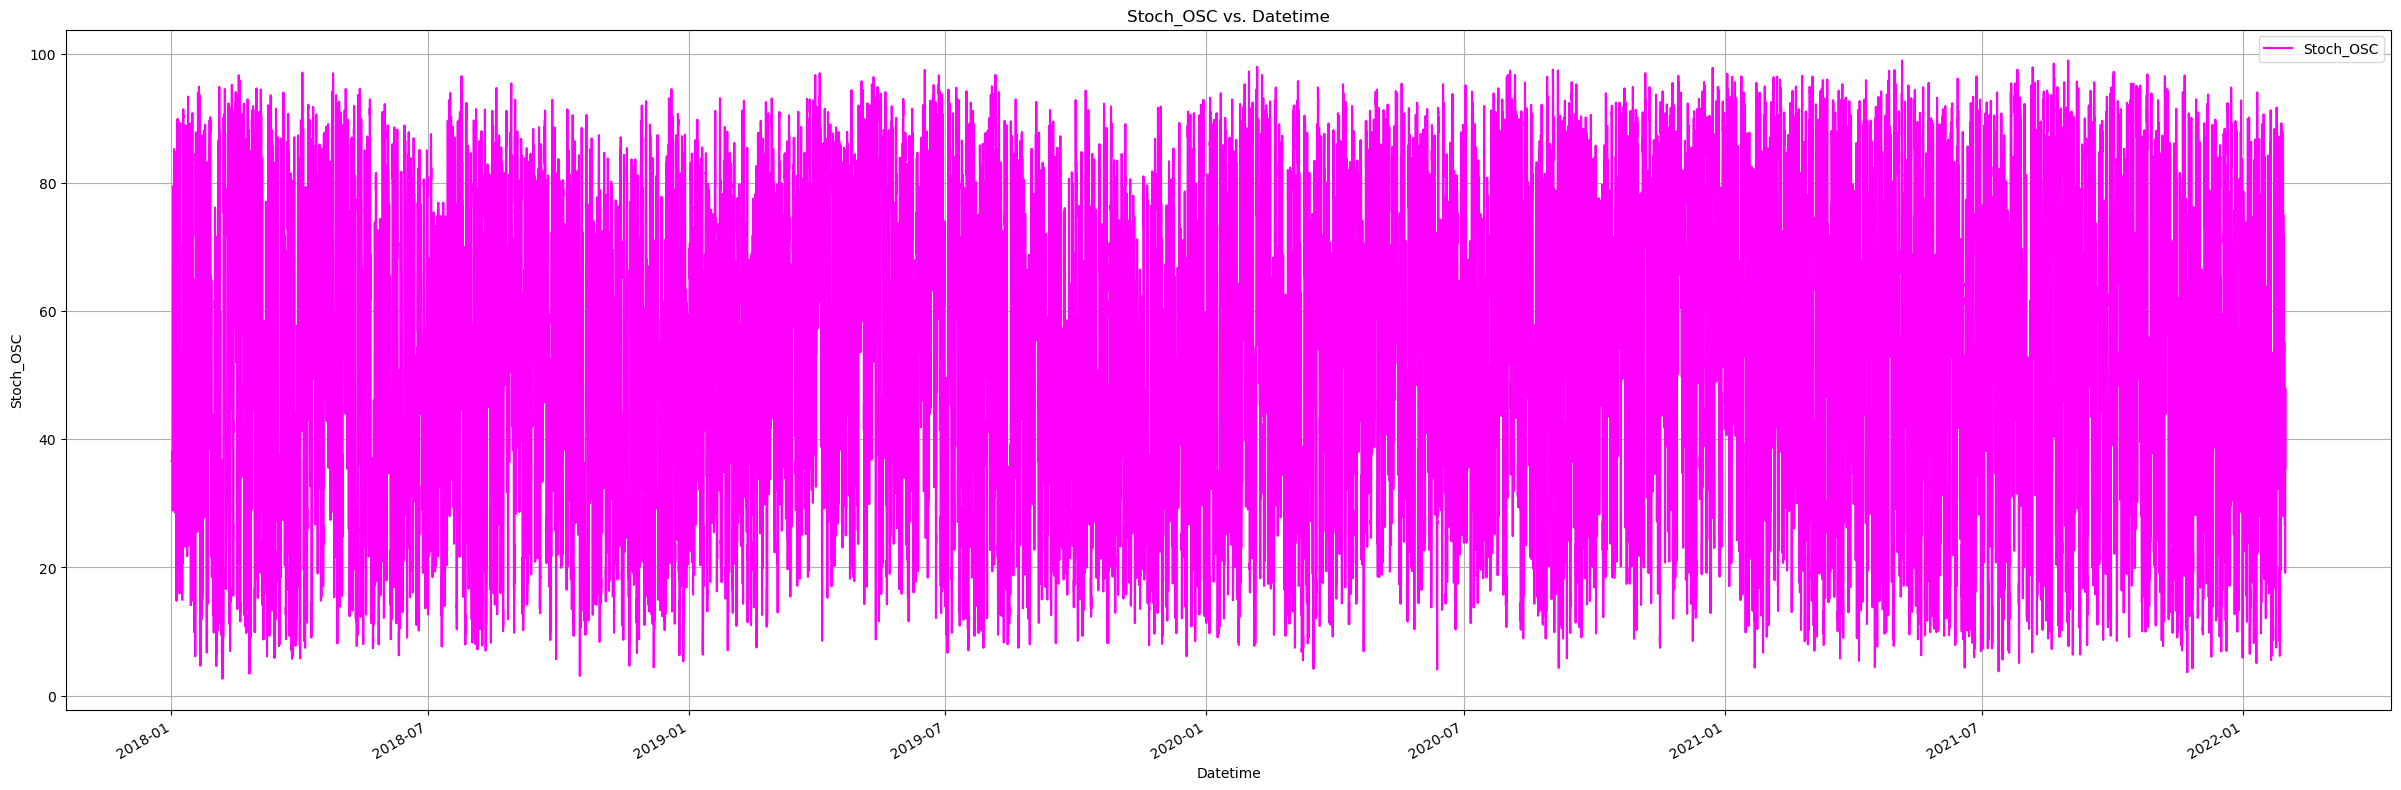

**ADX_14 vs Time**


**Composite_Indicator vs Time**


In [10]:
#Calculate the trading signals based on the Composite Indicator and ADX
data["Signal"]=np.where(((data["ADX_14"]>25)&(data["composite"]<=87)),-1,np.where(((data["ADX_14"]>25)&(data["composite"]>87)),1,np.where(((data["ADX_14"]<=25)&(data["composite"]>87)),1,np.where(((data["ADX_14"]<=25)&(data["composite"]<=87)),-1,0))))

In [11]:
from backtesting import Backtest,Strategy #importing Backtest,Strategy
from backtesting.lib import TrailingStrategy #importing Trailing Stop Loss Strategy

Loading BokehJS ...

In [12]:
import logging

# Configure logging (adjust as needed)
logging.basicConfig(filename='backtest_logs_final_4.log', level=logging.INFO)

# Define the trading strategy using a trailing Stop-Loss
class SignalStrategy(TrailingStrategy):

    def init(self):
        super().init()
        super().set_trailing_sl(3)  # Set trailing Stoploss at the range of 4*ATR

    def next(self):
        super().next()

        current_signal = self.data.Signal[-1]
        price = self.data.Close[-1]
        current_atr = self.data.ATR[-1]
        
        if current_signal == 1:  # Buy Signal
            if not self.position:
                self.buy()
                logging.info(f",{self.data.index[-1]},1,{self.data.Open[-1]},{self.data.High[-1]},{self.data.Low[-1]},{self.data.Close[-1]},{self.data.volume[-1]}")
            elif self.position.is_short:
                self.position.close()
                logging.info(f",{self.data.index[-1]},1,{self.data.Open[-1]},{self.data.High[-1]},{self.data.Low[-1]},{self.data.Close[-1]},{self.data.volume[-1]}")
                self.buy()
                logging.info(f",{self.data.index[-1]},1,{self.data.Open[-1]},{self.data.High[-1]},{self.data.Low[-1]},{self.data.Close[-1]},{self.data.volume[-1]}")
            else:
                logging.info(f",{self.data.index[-1]},0,{self.data.Open[-1]},{self.data.High[-1]},{self.data.Low[-1]},{self.data.Close[-1]},{self.data.volume[-1]}")
        elif current_signal == -1:  # Sell Signal
            if self.position.is_long :
                self.position.close()
                logging.info(f",{self.data.index[-1]},-1,{self.data.Open[-1]},{self.data.High[-1]},{self.data.Low[-1]},{self.data.Close[-1]},{self.data.volume[-1]}")
                if current_atr*100 < price:
                    self.sell()
                    logging.info(f",{self.data.index[-1]},-1,{self.data.Open[-1]},{self.data.High[-1]},{self.data.Low[-1]},{self.data.Close[-1]},{self.data.volume[-1]}")
            else:
                logging.info(f",{self.data.index[-1]},0,{self.data.Open[-1]},{self.data.High[-1]},{self.data.Low[-1]},{self.data.Close[-1]},{self.data.volume[-1]}")

# Run the Backtest
bt = Backtest(data, SignalStrategy, cash=150_000, commission=0.0015, trade_on_close=True)  # commission is set at 0.15%

# Backtesting Results

In [13]:
stats = bt.run()
print(stats) # Backtest results

Start                     2018-01-01 05:30:00
End                       2022-01-31 05:30:00
Duration                   1491 days 00:00:00
Exposure Time [%]                   29.393786
Equity Final [$]               4340777.754325
Equity Peak [$]                4486897.061285
Return [%]                        2793.851836
Buy & Hold Return [%]              172.224649
Return (Ann.) [%]                  127.788995
Volatility (Ann.) [%]               76.613939
Sharpe Ratio                          1.66796
Sortino Ratio                        9.214974
Calmar Ratio                         8.124894
Max. Drawdown [%]                  -15.728081
Avg. Drawdown [%]                   -1.968234
Max. Drawdown Duration      163 days 03:00:00
Avg. Drawdown Duration        5 days 10:00:00
# Trades                                  931
Win Rate [%]                        41.783029
Best Trade [%]                      27.796359
Worst Trade [%]                     -4.477529
Avg. Trade [%]                    

In [14]:
bt.plot(resample=False,superimpose=False)

GridPlot(id='p1227', ...)

In [35]:
data = pd.read_csv("backtest_logs_final_4.log",sep=",",header=None)

In [36]:
data.rename(columns = {1:'datetime' , 2:'signals' , 3:'open' , 4:'high' , 5:'low', 6:'close', 7:'volume'},inplace=True)

In [37]:
data.drop(0,axis=1,inplace=True)

In [38]:
data['Signal'] = data['signals']

In [39]:
data.drop('signals',axis=1,inplace=True)

In [40]:
data.rename(columns = {'Signal' : 'signals'},inplace=True)

In [41]:
data

datetime      open      high       low     close  \
0      2018-01-01 06:30:00  13528.99  13595.89  13155.38  13203.06   
1      2018-01-01 07:30:00  13203.00  13418.43  13200.00  13330.18   
2      2018-01-01 08:30:00  13330.26  13611.27  13290.00  13410.03   
3      2018-01-01 09:30:00  13434.98  13623.29  13322.15  13601.01   
4      2018-01-01 10:30:00  13615.20  13699.00  13526.50  13558.99   
...                    ...       ...       ...       ...       ...   
36037  2022-01-31 01:30:00  37512.37  37740.00  37351.63  37684.45   
36038  2022-01-31 02:30:00  37684.45  37762.60  37492.25  37729.00   
36039  2022-01-31 03:30:00  37729.00  37855.54  37625.41  37785.78   
36040  2022-01-31 04:30:00  37785.78  38230.00  37778.46  37881.76   
36041  2022-01-31 05:30:00  37881.75  37951.07  36828.32  36829.30   

            volume  signals  
0       383.697006        0  
1       429.064572        0  
2       420.087030        0  
3       340.807329        0  
4       404.229046        0  
...            ...      ...  
36037  1037.922560        0  
36038   874.060520        0  
36039   734.658550        0  
36040  1728.811800        0  
36041  2907.710960        0  

[36042 rows x 7 columns]

In [43]:
data.to_csv('Backtesting_Logs.csv', index=False, date_format='%Y-%m-%d %H:%M:%S')